In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential

In [ ]:
csv_file = "corrected_csv_file.csv"
data = pd.read_csv(csv_file)
data.head(10)

,Sample No,Image Name,SPAD Value
0,1,IMG_3547.JPG,89.9
1,1,IMG_3548.JPG,89.9
2,1,IMG_3549.JPG,89.9
3,1,IMG_3550.JPG,89.9
4,1,IMG_3551.JPG,89.9
5,1,IMG_3552.JPG,89.9
6,1,IMG_3556.JPG,89.9
7,2,IMG_3557.JPG,98.7
8,2,IMG_3558.JPG,98.7
9,2,IMG_3559.JPG,98.7


In [ ]:
image_folder = "capscum_org3/"
weights_path = "efficientnetb0_notop.h5"

In [ ]:
def load_data(dataframe, image_folder):
    images = []
    labels = []
    for _, row in dataframe.iterrows():
        img_path = image_folder + row["Image Name"]
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        images.append(image)
        labels.append(row["SPAD Value"])
    return np.array(images), np.array(labels)

In [ ]:
images, labels = load_data(data, image_folder)

In [ ]:
images = images / 255.0

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
for train_index, test_index in kf.split(images):
    X_train, X_test = images[train_index], images[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


In [ ]:
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights=None)
base_model.load_weights(weights_path)
base_model.trainable = False

In [ ]:
model = Sequential([
        base_model,
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D(),

        Dense(256, activation='relu'),
        Dropout(0.6),
        Dense(128, activation='relu'),
        
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        
        Dropout(0.5),
        Dense(64, activation='sigmoid'),
        Dropout(0.5),
        Dense(1, activation='linear')
    ])

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [ ]:
history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=200,  # Reduced number of epochs to avoid overfitting with small dataset
        verbose=1  # Suppress training output for clarity
    )

Epoch 1/200
4/4 [==============================] - 22s 2s/step - loss: 4225.0542 - mae: 60.2663 - mse: 4225.0537 - val_loss: 4755.1582 - val_mae: 65.0873 - val_mse: 4755.1587
Epoch 2/200
4/4 [==============================] - 1s 156ms/step - loss: 3991.9023 - mae: 58.2948 - mse: 3991.9026 - val_loss: 4466.1543 - val_mae: 62.8289 - val_mse: 4466.1543
Epoch 3/200
4/4 [==============================] - 1s 155ms/step - loss: 3826.7283 - mae: 56.8622 - mse: 3826.7285 - val_loss: 4357.8076 - val_mae: 61.9608 - val_mse: 4357.8071
Epoch 4/200
4/4 [==============================] - 1s 156ms/step - loss: 3733.9194 - mae: 56.0475 - mse: 3733.9197 - val_loss: 4304.4966 - val_mae: 61.5291 - val_mse: 4304.4966
Epoch 5/200
4/4 [==============================] - 1s 158ms/step - loss: 3671.0627 - mae: 55.4707 - mse: 3671.0630 - val_loss: 4284.2378 - val_mae: 61.3642 - val_mse: 4284.2378
Epoch 6/200
4/4 [==============================] - 1s 155ms/step - loss: 3628.0725 - mae: 55.0943 - mse: 3628.0730 - 

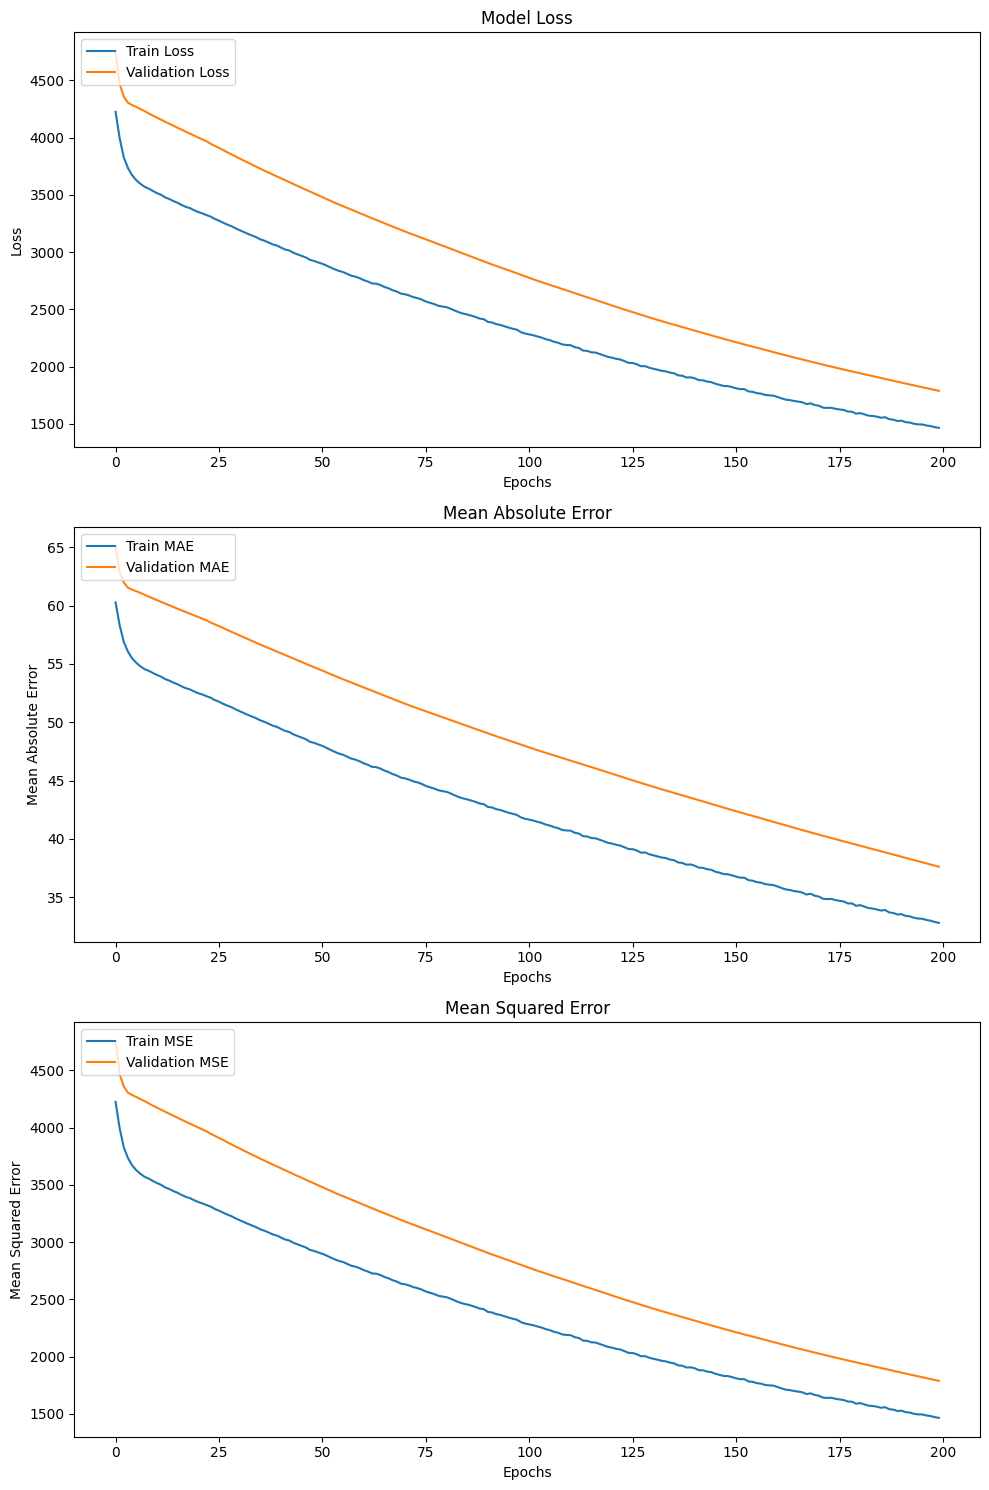

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot training and validation loss
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Model Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='upper left')

axs[1].plot(history.history['mae'], label='Train MAE')
axs[1].plot(history.history['val_mae'], label='Validation MAE')
axs[1].set_title('Mean Absolute Error')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Mean Absolute Error')
axs[1].legend(loc='upper left')

axs[2].plot(history.history['mse'], label='Train MSE')
axs[2].plot(history.history['val_mse'], label='Validation MSE')
axs[2].set_title('Mean Squared Error')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Mean Squared Error')
axs[2].legend(loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
y_pred = model.predict(X_test)
print(f'Shape of y_pred before flattening: {y_pred.shape}')
y_pred_reshaped = y_pred.mean(axis=(1, 2, 3)).flatten()

print(f'Shape of y_pred after reshaping: {y_pred_reshaped.shape}')

2/2 [==============================] - 4s 48ms/step
Shape of y_pred before flattening: (35, 7, 7, 1)
Shape of y_pred after reshaping: (35,)


In [ ]:
fold_mae = []
fold_mse = []
mae = mean_absolute_error(y_test, y_pred_reshaped)
mse = mean_squared_error(y_test, y_pred_reshaped)
    
fold_mae.append(mae)
fold_mse.append(mse)
    
print(f'Fold MAE: {mae}, Fold MSE: {mse}')

Fold MAE: 28.587731334141324, Fold MSE: 1108.9968342931297


In [ ]:
avg_mae = np.mean(fold_mae)
avg_mse = np.mean(fold_mse)

print(f'Average MAE: {avg_mae}, Average MSE: {avg_mse}')

Average MAE: 28.587731334141324, Average MSE: 1108.9968342931297


In [ ]:
avg_mae = np.mean(fold_mae)
avg_mse = np.mean(fold_mse)

print(f'Average MAE: {avg_mae}, Average MSE: {avg_mse}')

Average MAE: 28.587731334141324, Average MSE: 1108.9968342931297
